In [ ]:
!pip install ultralytics --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from ultralytics import YOLO
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import random


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
pose_model = YOLO("/content/drive/MyDrive/DU/yolo11n-pose.pt")
ppe_model  = YOLO("/content/drive/MyDrive/DU/train4/weights/best.pt")


In [ ]:
# Define all PPE classes
ppe_classes_all = [
    'Gloves',
    'Goggles',
    'Helmet',
    'Mask',
    'NO-Goggles',
    'NO-helmet',
    'NO-mask',
    'NO-safety Vest',
    'Work clothes',
    'hand',
    'safety vest'
]

# Subset of classes
wanted_classes = ["Helmet", "Mask", "NO-helmet", "NO-mask", "NO-safety Vest", "safety vest"]

# Keypoint mappings for validating specific PPE detections
ppe_keypoints_map = {
    'Helmet': [0, 1, 2, 3, 4],        # Head/face area
    'Mask': [2, 3 , 5 ,6],            # Face area + shoulders
    'safety vest': [5, 6, 11, 12]     # Torso (shoulders + hips)
}

# IOU thresholds per PPE class (used to validate detections against keypoint-defined areas)
iou_thresholds = {
    'Helmet': 0.01,
    'Mask': 0.1,
    'safety vest': 0.2
}

# conflicting classes
conflict_pairs = [
    ("Helmet", "NO-helmet"),
    ("Mask", "NO-mask"),
    ("safety vest", "NO-safety Vest")
]


def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB-xA) * max(0, yB-yA)
    boxAArea = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)


def remove_overlaps(detections, iou_thresh=0.8):
    final_dets = []
    # Sort detections by area (largest first)
    detections = sorted(detections, key=lambda x: (x[2]-x[1])*(x[3]-x[0]), reverse=True)
    for det in detections:
        keep = True
        for kept in final_dets:
            if iou(det, kept) > iou_thresh:
                keep = False
                break
        if keep:
            final_dets.append(det)
    return final_dets

def process_frame(img, pose_model, ppe_model, pose_thresh=0.5, ppe_thresh=0.4):
    annotated_img = img.copy()
    pose_results = pose_model.predict(img, imgsz=640, verbose=False)[0]

    human_boxes = []
    human_keypoints = []

    for box, conf, kpts in zip(pose_results.boxes.xyxy,
                               pose_results.boxes.conf,
                               pose_results.keypoints.data.cpu().numpy()):
        score = float(conf.item())
        if score < pose_thresh:
            continue
        x_min, y_min, x_max, y_max = map(int, box.tolist())
        pad = int(0.05 * (y_max - y_min))
        y_min = max(0, y_min - pad)
        human_boxes.append([x_min, y_min, x_max, y_max])
        human_keypoints.append(kpts)

    for i, (box, kp) in enumerate(zip(human_boxes, human_keypoints)):
        x1, y1, x2, y2 = box
        human_crop = img[y1:y2, x1:x2]
        ppe_results = ppe_model.predict(human_crop, imgsz=640, verbose=False)[0]

        raw_detections = []
        for det, cls, conf in zip(ppe_results.boxes.xyxy,
                                  ppe_results.boxes.cls,
                                  ppe_results.boxes.conf):
            score = float(conf.item())
            if score < ppe_thresh:
                continue
            cls = int(cls)
            class_name = ppe_classes_all[cls]
            if class_name not in wanted_classes:
                continue

            x_min, y_min, x_max, y_max = map(int, det)
            x_min += x1
            x_max += x1
            y_min += y1
            y_max += y1

            if class_name in ppe_keypoints_map and not class_name.startswith("NO-"):
                if class_name == "Mask":
                    kp_indices = [2, 3, 5, 6]
                else:
                    kp_indices = ppe_keypoints_map[class_name]

                kp_coords = kp[kp_indices, :2]
                valid_kp = kp_coords[(kp_coords[:, 0] > 0) & (kp_coords[:, 1] > 0)]
                if valid_kp.shape[0] >= 1:
                    valid_box = [
                        int(valid_kp[:, 0].min()),
                        int(valid_kp[:, 1].min()),
                        int(valid_kp[:, 0].max()),
                        int(valid_kp[:, 1].max())
                    ]

                    if class_name == "Helmet":
                        margin = int(0.6 * (valid_box[3] - valid_box[1]))
                        valid_box[1] = max(0, valid_box[1] - margin)

                    threshold = iou_thresholds[class_name]
                    if iou([x_min, y_min, x_max, y_max], valid_box) < threshold:
                        continue

            raw_detections.append((class_name, [x_min, y_min, x_max, y_max], score))

        final_raw = []
        for cls_name in set([c for c, _, _ in raw_detections]):
            boxes_scores = [(b, s) for c, b, s in raw_detections if c == cls_name]
            boxes = [b for b, s in boxes_scores]
            kept = remove_overlaps(boxes, iou_thresh=0.8)
            for k in kept:
                scores_for_k = [s for b, s in boxes_scores if iou(b, k) > 0.5]
                score = max(scores_for_k) if len(scores_for_k) > 0 else 0.0
                final_raw.append((cls_name, k, score))

        detected_classes = list(set([c for c, _, _ in final_raw]))
        final_ppe = detected_classes.copy()
        for pos, neg in conflict_pairs:
            if pos in final_ppe and neg in final_ppe:
                final_ppe.remove(neg)
        final_ppe = [c for c in final_ppe if not c.startswith("NO-")]

        print(f"Human {i+1} final PPE after filtering:", final_ppe)

        has_helmet = "Helmet" in final_ppe
        has_mask = "Mask" in final_ppe
        has_vest = "safety vest" in final_ppe
        count = sum([has_helmet, has_mask, has_vest])

        if count == 3:
            color = (0, 255, 0)
        elif count >= 1:
            color = (0, 255, 255)
        else:
            color = (0, 0, 255)

        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(annotated_img, f"{i+1}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        color_map = {
            'Helmet': (255, 0, 0),
            'Mask': (255, 255, 0),
            'safety vest': (0, 165, 255),
        }

        for cls_name, bbox, conf in final_raw:
            if cls_name not in final_ppe:
                continue
            x_min, y_min, x_max, y_max = bbox
            color = color_map.get(cls_name, (0, 0, 255))
            cv2.rectangle(annotated_img, (x_min, y_min), (x_max, y_max), color, 2)
            cv2.putText(annotated_img, f"{cls_name} {conf:.2f}", (x_min, y_min-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return annotated_img


def process_image(img_path, pose_model, ppe_model, pose_thresh=0.5, ppe_thresh=0.4):
    img = cv2.imread(img_path)
    if img is None:
        return
    annotated = process_frame(img, pose_model, ppe_model, pose_thresh=pose_thresh, ppe_thresh=ppe_thresh)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(img_path))
    plt.axis("off")
    plt.show()


def process_video(video_path, pose_model, ppe_model, save_output=False, out_path="output.mp4", pose_thresh=0.5, ppe_thresh=0.4):
    cap = cv2.VideoCapture(video_path)
    if save_output:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        fps = cap.get(cv2.CAP_PROP_FPS)
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

    frame_id = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_id += 1
        annotated = process_frame(frame, pose_model, ppe_model, pose_thresh=pose_thresh, ppe_thresh=ppe_thresh)

        if frame_id % 30 == 0:
            plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_id}")
            plt.axis("off")
            plt.show()

        if save_output:
            out.write(annotated)

    cap.release()
    if save_output:
        out.release()


def process_input(input_path, pose_model, ppe_model, save_output=False, out_path="output.mp4", pose_thresh=0.5, ppe_thresh=0.4):
    if not os.path.exists(input_path):
        print("Path not found:", input_path)
        return

    if os.path.isfile(input_path):
        ext = os.path.splitext(input_path)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp"]:
            # a single image
            process_image(input_path, pose_model, ppe_model, pose_thresh=pose_thresh, ppe_thresh=ppe_thresh)
        elif ext in [".mp4", ".avi", ".mov", ".mkv"]:
            # a single video
            process_video(input_path, pose_model, ppe_model, save_output=save_output, out_path=out_path, pose_thresh=pose_thresh, ppe_thresh=ppe_thresh)
        else:
            print("Unsupported file type:", ext)

    elif os.path.isdir(input_path):
        # Process all images and videos inside the directory
        image_files = sorted(glob.glob(os.path.join(input_path, "*.[jpJP][pnPN]*[gG]*")))
        video_files = sorted(glob.glob(os.path.join(input_path, "*.[mpMP][4vV]*")))

        for img_file in image_files:
            process_image(img_file, pose_model, ppe_model, pose_thresh=pose_thresh, ppe_thresh=ppe_thresh)

        for vid_file in video_files:
            process_video(vid_file, pose_model, ppe_model, save_output=save_output, out_path=out_path, pose_thresh=pose_thresh, ppe_thresh=ppe_thresh)
    else:
        print("Unknown input type:", input_path)


In [ ]:
process_input("/content/drive/MyDrive/DU/test/images", pose_model, ppe_model, save_output= True,pose_thresh=0.3, ppe_thresh=0.5)


Human 1 final PPE after filtering: ['safety vest', 'Helmet']
Human 2 final PPE after filtering: ['safety vest', 'Helmet']
Human 3 final PPE after filtering: ['safety vest', 'Helmet']
Human 1 final PPE after filtering: ['safety vest', 'Helmet']
Human 2 final PPE after filtering: ['safety vest', 'Helmet']
Human 3 final PPE after filtering: ['Helmet']
Human 1 final PPE after filtering: ['safety vest', 'Helmet']
Human 1 final PPE after filtering: ['Helmet']
Human 1 final PPE after filtering: ['Mask']
Human 2 final PPE after filtering: ['Mask']
Human 3 final PPE after filtering: ['Mask']
Human 4 final PPE after filtering: ['Mask']
Human 5 final PPE after filtering: ['Mask']
Human 1 final PPE after filtering: ['safety vest', 'Helmet']
Human 1 final PPE after filtering: []
Human 1 final PPE after filtering: ['safety vest', 'Helmet']
Human 1 final PPE after filtering: ['safety vest', 'Helmet']
Human 2 final PPE after filtering: []
Human 3 final PPE after filtering: ['safety vest', 'Helmet']
Hu

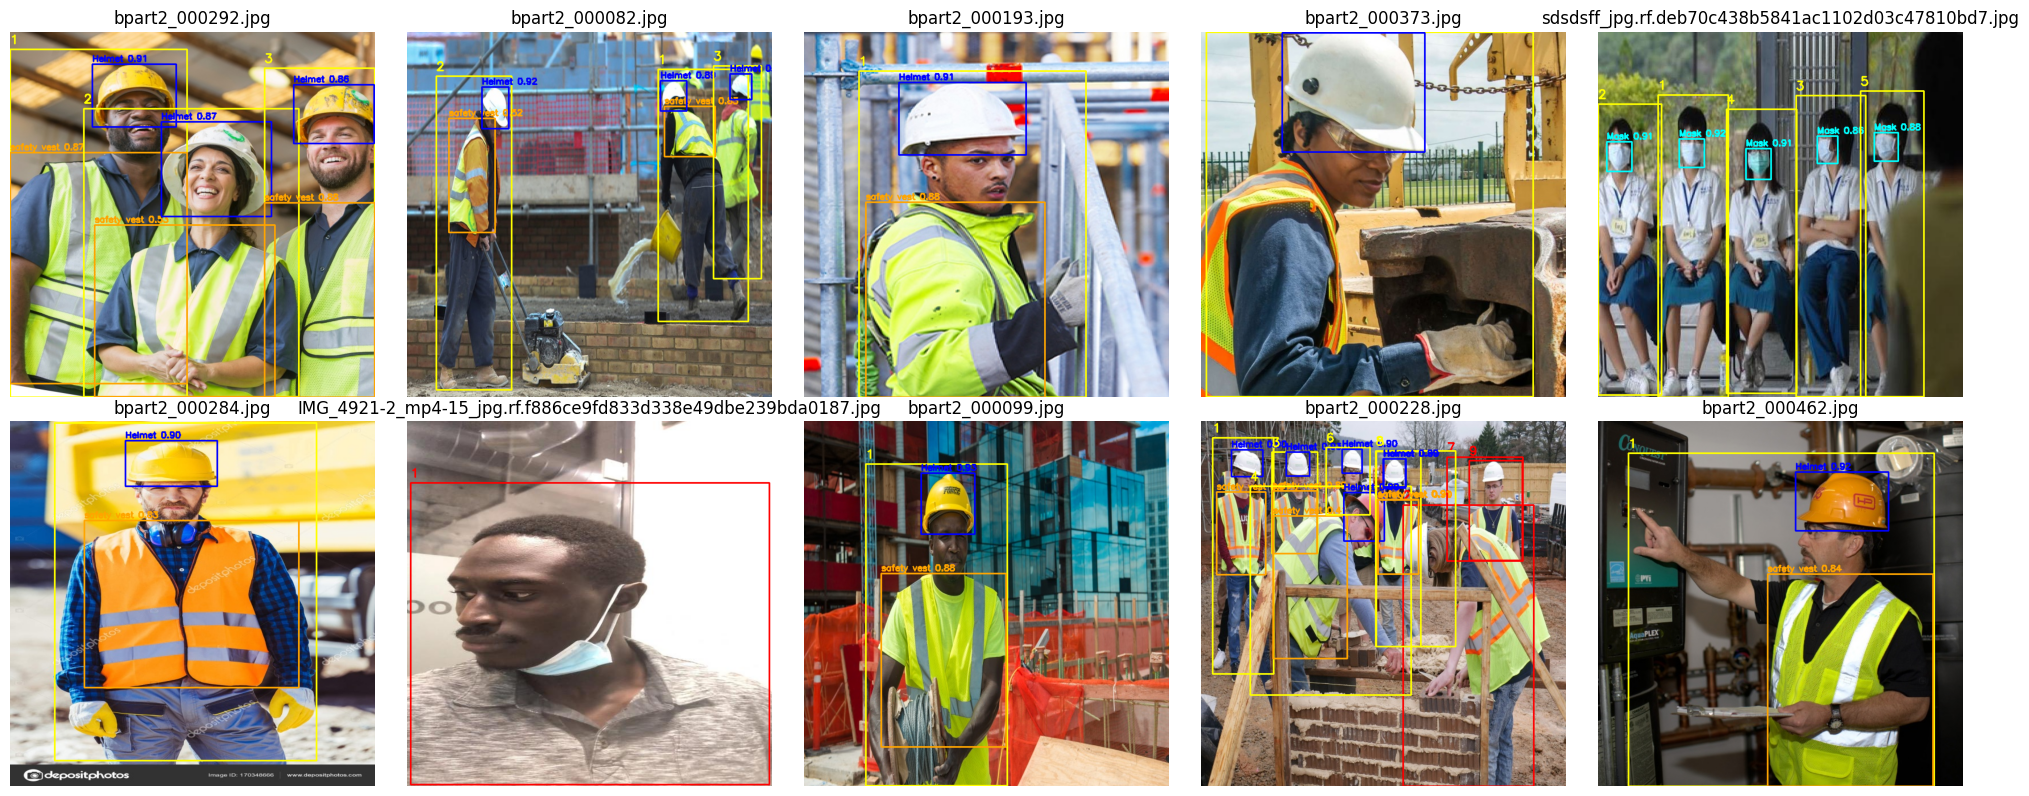

In [ ]:
img_dir = "/content/drive/MyDrive/DU/test/images"

all_imgs = [os.path.join(img_dir, f) for f in os.listdir(img_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, 10)

rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

for idx, img_path in enumerate(sample_imgs):
    img = cv2.imread(img_path)
    annotated = process_frame(img, pose_model, ppe_model,
                              pose_thresh=0.3, ppe_thresh=0.4)
    axes[idx].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(os.path.basename(img_path))
    axes[idx].axis("off")

plt.tight_layout()
plt.show()


# all_class

In [ ]:
ppe_classes_all = [
    'Gloves',
    'Goggles',
    'Helmet',
    'Mask',
    'NO-Goggles',
    'NO-helmet',
    'NO-mask',
    'NO-safety Vest',
    'Work clothes',
    'hand',
    'safety vest'
]

wanted_classes = ["Helmet", "Mask", "NO-helmet", "NO-mask", "NO-safety Vest", "safety vest"]

ppe_keypoints_map = {
    'Helmet': [0, 1, 2, 3, 4],
    'Mask': [2, 3 , 5 ,6],
    'safety vest': [5, 6, 11, 12]
}

iou_thresholds = {
    'Helmet': 0.01,
    'Mask': 0.1,
    'safety vest': 0.2
}

conflict_pairs = [
    ("Helmet", "NO-helmet"),
    ("Mask", "NO-mask"),
    ("safety vest", "NO-safety Vest")
]

PPE_CONF_THRESHOLD = 0.4

SAME_CLASS_IOU_SUPPRESS = 0.8


def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(1, (boxA[2] - boxA[0])) * max(1, (boxA[3] - boxA[1]))
    boxBArea = max(1, (boxB[2] - boxB[0])) * max(1, (boxB[3] - boxB[1]))
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)


def suppress_similar_detections(detections, iou_thresh=SAME_CLASS_IOU_SUPPRESS):
    kept = []
    by_class = {}
    for cls, bbox, conf in detections:
        by_class.setdefault(cls, []).append((bbox, conf))

    for cls, items in by_class.items():
        items_with_area = []
        for bbox, conf in items:
            area = max(0, (bbox[2]-bbox[0])) * max(0, (bbox[3]-bbox[1]))
            items_with_area.append((bbox, conf, area))
        items_with_area.sort(key=lambda x: x[2], reverse=True)

        keep_flags = [True] * len(items_with_area)
        for i in range(len(items_with_area)):
            if not keep_flags[i]:
                continue
            bi = items_with_area[i][0]
            for j in range(i+1, len(items_with_area)):
                if not keep_flags[j]:
                    continue
                bj = items_with_area[j][0]
                if iou(bi, bj) > iou_thresh:
                    keep_flags[j] = False

        for flag, (bbox, conf, area) in zip(keep_flags, items_with_area):
            if flag:
                kept.append((cls, bbox, conf))

    return kept


def process_frame(img, pose_model, ppe_model):
    annotated_img = img.copy()
    pose_results = pose_model.predict(img, imgsz=640, verbose=False)[0]

    human_boxes = []
    human_keypoints = []

    for box, conf, kpts in zip(pose_results.boxes.xyxy,
                               pose_results.boxes.conf,
                               pose_results.keypoints.data.cpu().numpy()):
        score = float(conf.item())
        if score < 0.3:
            continue
        x_min, y_min, x_max, y_max = map(int, box.tolist())
        human_boxes.append([x_min, y_min, x_max, y_max])
        human_keypoints.append(kpts)

    for i, (box, kp) in enumerate(zip(human_boxes, human_keypoints)):
        x1, y1, x2, y2 = box
        h = y2 - y1
        w = x2 - x1

        pad_top = int(0.20 * h)
        y1_crop = max(0, y1 - pad_top)
        human_crop = img[y1_crop:y2, x1:x2]

        ppe_results = ppe_model.predict(human_crop, imgsz=640, verbose=False)[0]

        raw_detections = []


        if hasattr(ppe_results.boxes, 'xyxy'):
            ppe_boxes = ppe_results.boxes.xyxy
            ppe_confs = ppe_results.boxes.conf if hasattr(ppe_results.boxes, 'conf') else None
            ppe_classes = ppe_results.boxes.cls
        else:

            ppe_boxes = []
            ppe_confs = []
            ppe_classes = []

        for det, conf, cls in zip(ppe_boxes, ppe_confs, ppe_classes):
            cls = int(cls)
            conf_val = float(conf.item()) if hasattr(conf, 'item') else float(conf)
            if conf_val < PPE_CONF_THRESHOLD:
                continue
            class_name = ppe_classes_all[cls]
            if class_name not in wanted_classes:
                continue

            x_min, y_min, x_max, y_max = map(int, det.tolist())
            x_min_global = x_min + x1
            x_max_global = x_max + x1
            y_min_global = y_min + y1_crop
            y_max_global = y_max + y1_crop

            if class_name in ppe_keypoints_map:
                if class_name == "Mask":
                    kp_indices = [2, 3, 5, 6]
                else:
                    kp_indices = ppe_keypoints_map[class_name]

                kp_coords = kp[kp_indices, :2]
                valid_kp = kp_coords[(kp_coords[:, 0] > 0) & (kp_coords[:, 1] > 0)]
                if valid_kp.shape[0] >= 1:
                    valid_box = [
                        int(valid_kp[:, 0].min()),
                        int(valid_kp[:, 1].min()),
                        int(valid_kp[:, 0].max()),
                        int(valid_kp[:, 1].max())
                    ]

                    if class_name == "Helmet":
                        margin = int(0.6 * (valid_box[3] - valid_box[1]))
                        valid_box[1] = max(0, valid_box[1] - margin)

                    threshold = iou_thresholds.get(class_name, 0.0)
                    if iou([x_min_global, y_min_global, x_max_global, y_max_global], valid_box) < threshold:
                        continue

            raw_detections.append((class_name, [x_min_global, y_min_global, x_max_global, y_max_global], conf_val))

        raw_detections = suppress_similar_detections(raw_detections, iou_thresh=SAME_CLASS_IOU_SUPPRESS)

        detected_classes = list(set([c for c, _, _ in raw_detections]))
        final_ppe = detected_classes.copy()

        for pos, neg in conflict_pairs:
            if pos in final_ppe and neg in final_ppe:
                try:
                    final_ppe.remove(neg)
                except ValueError:
                    pass

        # print(f"Human {i+1} final PPE after filtering:", final_ppe)

        has_helmet = 'Helmet' in final_ppe
        has_mask = 'Mask' in final_ppe
        has_vest = 'safety vest' in final_ppe
        num_pos = sum([has_helmet, has_mask, has_vest])

        if num_pos == 3:
            human_box_color = (0, 255, 0)
        elif num_pos >= 1:
            human_box_color = (0, 255, 255)
        else:
            human_box_color = (0, 0, 255)

        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), human_box_color, 2)
        cv2.putText(annotated_img, f"{i+1}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, human_box_color, 2)

        color_map = {
            'Helmet': (255, 0, 0),
            'Mask': (255, 255, 0),
            'safety vest': (0, 165, 255),
            'NO-helmet': (100, 0, 0),
            'NO-mask': (100, 100, 0),
            'NO-safety Vest': (50, 50, 50)
        }

        for cls_name, bbox, conf in raw_detections:
            if cls_name not in final_ppe:
                continue
            x_min, y_min, x_max, y_max = bbox
            color = color_map.get(cls_name, (0, 0, 255))
            cv2.rectangle(annotated_img, (x_min, y_min), (x_max, y_max), color, 2)
            cv2.putText(annotated_img, f"{cls_name} {conf:.2f}", (x_min, y_min-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return annotated_img


def process_image(img_path, pose_model, ppe_model):
    img = cv2.imread(img_path)
    if img is None:
        print("Couldn't read image:", img_path)
        return
    annotated = process_frame(img, pose_model, ppe_model)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(img_path))
    plt.axis("off")
    plt.show()


def process_video(video_path, pose_model, ppe_model, save_output=False, out_path="output.mp4"):
    cap = cv2.VideoCapture(video_path)
    if save_output:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        fps = cap.get(cv2.CAP_PROP_FPS)
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

    frame_id = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_id += 1
        annotated = process_frame(frame, pose_model, ppe_model)

        if frame_id % 30 == 0:
            plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_id}")
            plt.axis("off")
            plt.show()

        if save_output:
            out.write(annotated)

    cap.release()
    if save_output:
        out.release()


def process_input(input_path, pose_model, ppe_model, save_output=False, out_path="output.mp4"):
    if not os.path.exists(input_path):
        print("Path not found:", input_path)
        return

    if os.path.isfile(input_path):
        ext = os.path.splitext(input_path)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp"]:
            process_image(input_path, pose_model, ppe_model)
        elif ext in [".mp4", ".avi", ".mov", ".mkv"]:
            process_video(input_path, pose_model, ppe_model, save_output=save_output, out_path=out_path)
        else:
            print("Unsupported file type:", ext)

    elif os.path.isdir(input_path):
        image_files = sorted(glob.glob(os.path.join(input_path, "*.[jpJP][pnPN]*[gG]*")))
        video_files = sorted(glob.glob(os.path.join(input_path, "*.[mpMP][4vV]*")))

        for img_file in image_files:
            process_image(img_file, pose_model, ppe_model)

        for vid_file in video_files:
            process_video(vid_file, pose_model, ppe_model, save_output=save_output, out_path=out_path)
    else:
        print("Unknown input type:", input_path)


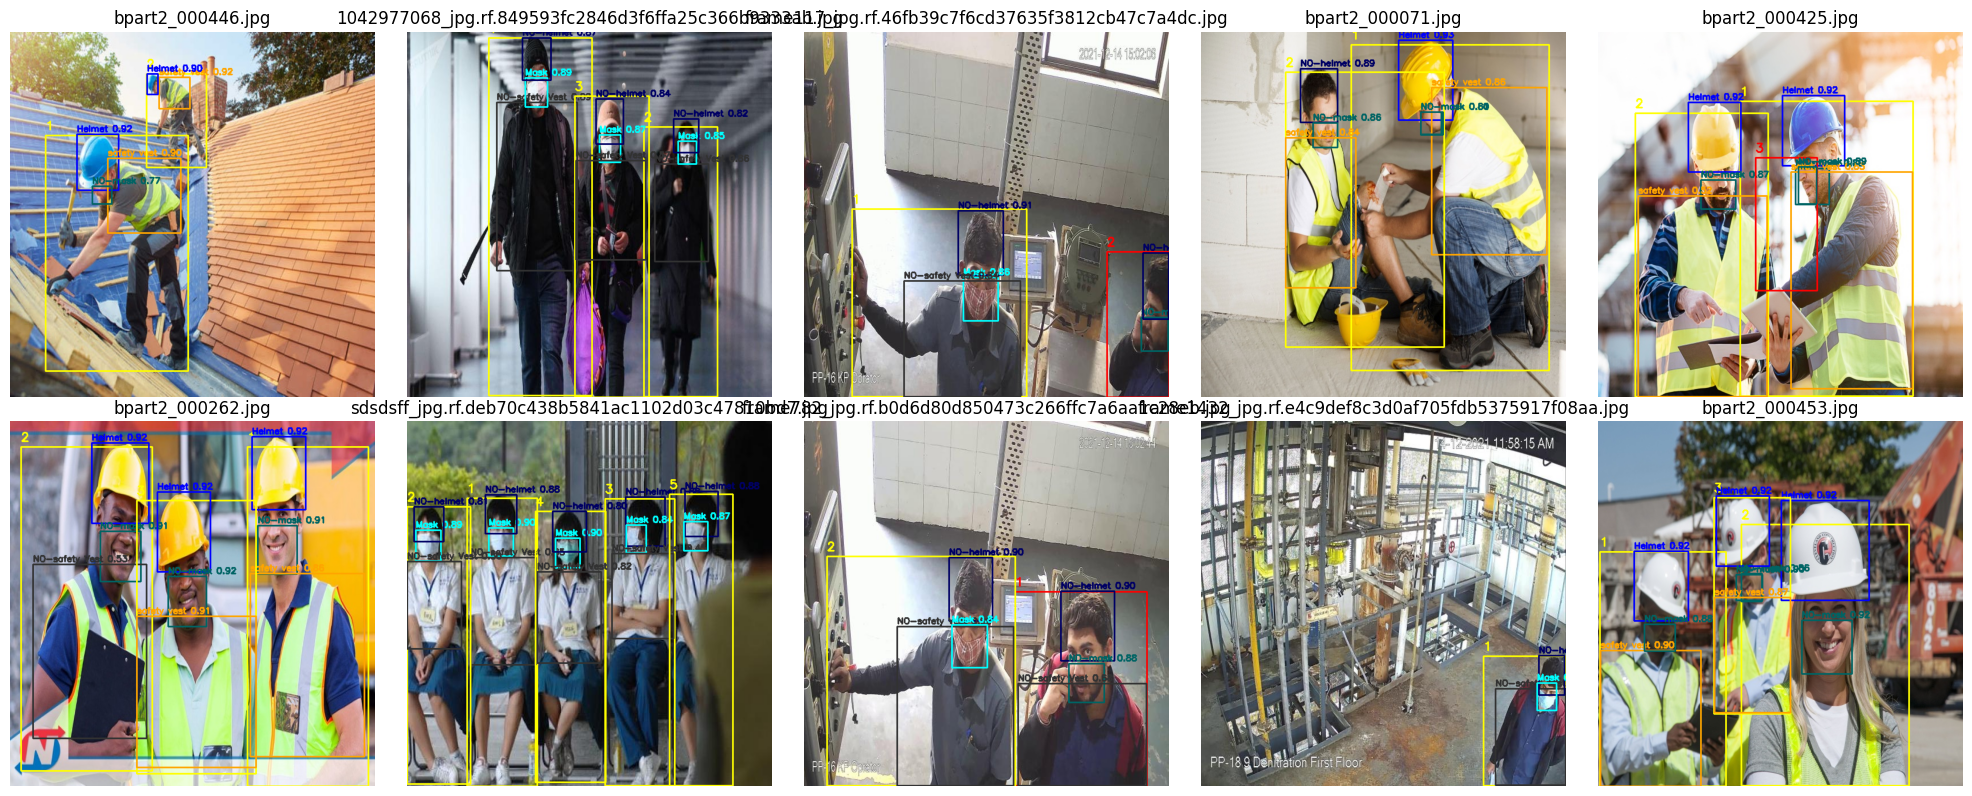

In [ ]:
img_dir = "/content/drive/MyDrive/DU/test/images"

all_imgs = [os.path.join(img_dir, f) for f in os.listdir(img_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, 10)

rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

for idx, img_path in enumerate(sample_imgs):
    img = cv2.imread(img_path)
    annotated = process_frame(img, pose_model, ppe_model)
    axes[idx].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(os.path.basename(img_path))
    axes[idx].axis("off")

plt.tight_layout()
plt.show()